In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch.nn.functional as F
from torchsummary import summary
import random

!pip install pymc

import pymc as pm
from matplotlib import cm


# Sanity Check

A sanity check was implemented on a very simple neural network that has a set of 6 weights (w11 to w31) that were distributed over two tanh activation functions and a sigmoid one. The reference labels for the comparison were calculated by setting each of the weights to 1.

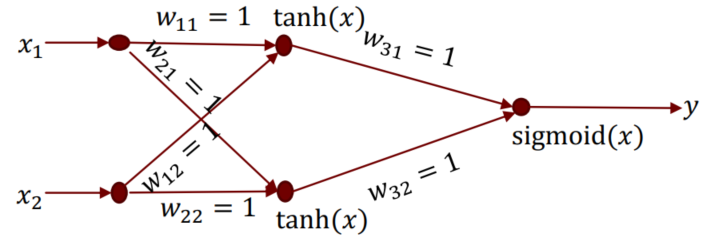

/usr/local/lib/python3.6/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 100000 of 100000 complete in 39.5 sec

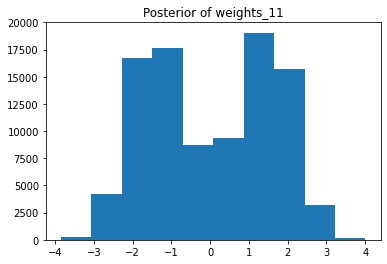

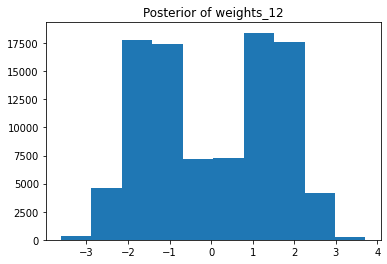

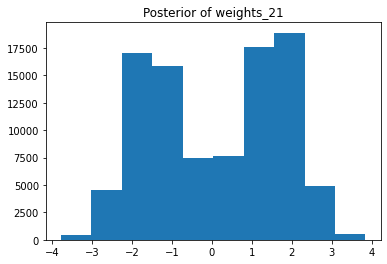

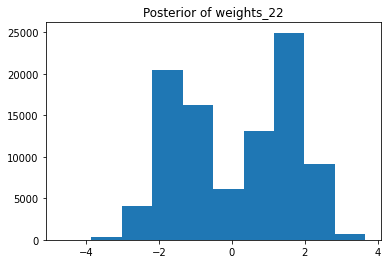

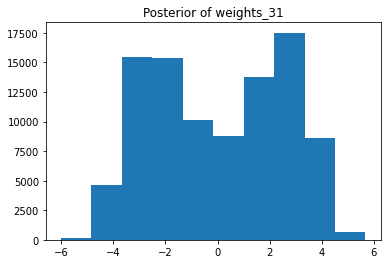

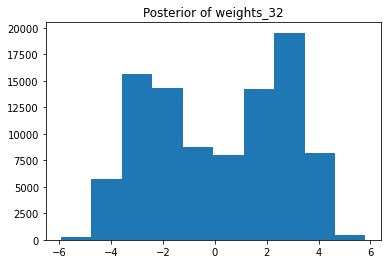

The mean of the weights w11, w12, w21, w22, w31, w32
[[0.048942236022680566 0.045266535090324654]
 [0.10912669365502316 0.10446367877406691]
 [0.05773112997234528 0.16810739973071132]]
The accuracy on train is:  100 %
The accuracy on test is:   99 %


In [ ]:
# function to generate a set of samples using the architecture presented above
def gen_sanity_check_samples():
    X = np.random.randn(100, 2)
    Y = np.tanh(X[:, 0] + X[:, 1])
    Y = 1. / (1. + np.exp(-(Y + Y)))
    Y = Y > 0.5
    return X, Y

# generate train and test sets
X_train, Y_train = gen_sanity_check_samples()
X_test, Y_test = gen_sanity_check_samples()

# generate the priors of the weights as Normal distribution with mean 0 and
# standard deviation of 1, and the initial value of 0.0
weights = np.empty((3,2), dtype=object)
for i in range(3):
    for j in range(X_train.shape[1]):
        weights[i][j] = pm.Normal('weights_%i%i' % (i, j), 0, 1, value = 0.0)

# function to check the output of the network by having the weights provided
def sanity_check_test(X, w):
    z1 = w[0][0] * X[:, 0] + w[0][1] * X[:, 1]
    z2 = w[1][0] * X[:, 0] + w[1][1] * X[:, 1]
    z3 = w[2][0] * np.tanh(z1) + w[2][1] * np.tanh(z2)
    y = 1. / (1. + np.exp(-(z3)))
    y = y > 0.5
    return y

# deterministic random variable to link the weights priors 
# with the observations in the form of the labels.
@pm.deterministic
def sanity_check_nn(X=X_train, w=weights):
    z1 = w[0][0] * X[:, 0] + w[0][1] * X[:, 1]
    z2 = w[1][0] * X[:, 0] + w[1][1] * X[:, 1]
    z3 = w[2][0] * np.tanh(z1) + w[2][1] * np.tanh(z2)
    y = 1. / (1. + np.exp(-(z3)))
    return y

# Bernoulli distribution used as the observed random variable 
# given the binary nature of our problem
observed  = pm.Bernoulli('bernoulli_obs', p=sanity_check_nn, value=Y_train, observed=True)

model = pm.Model([observed, pm.Container(weights)])
mcmc = pm.MCMC(model)
mcmc.sample(iter=100000,burn=5000)

# get the weights and their histogram and means
weights_mean = np.empty((3,2), dtype=object)
random_idx_sample = random.randint(0,9)
for i in range(3):
    for j in range(X_train.shape[1]):
        weight_samples = mcmc.trace('weights_%i%i' % (i, j))[:]
        plt.hist(weight_samples)
        plt.title('Posterior of weights_%i%i' % (i+1, j+1))
        plt.show()
        weights_mean[i][j] = np.mean(weight_samples)

print("The mean of the weights w11, w12, w21, w22, w31, w32")
print(weights_mean)

y_pred = sanity_check_test(X_train, weights_mean)
print("The accuracy on train is: ", np.sum(Y_train==y_pred), "%")

y_pred = sanity_check_test(X_test, weights_mean)
print("The accuracy on test is:  ", np.sum(Y_test==y_pred), "%")

#Binary Classification

For the Binary Classification, the Toy moons dataset was used, having generated 1000 samples with a noise coefficient of 0.3.

The split was done by using 80% train and 20% test from the initial dataset.

## Neural Network aproach

(1000, 2)


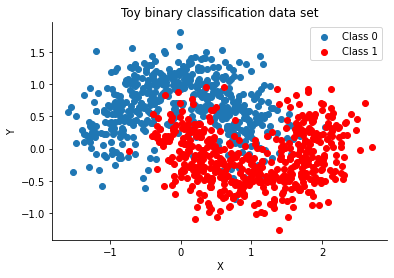

In [ ]:
X, Y = make_moons(noise=0.3, random_state=0, n_samples=1000)

print(X.shape)

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=.2)

train_X = torch.Tensor(train_X)
test_X = torch.Tensor(test_X)
train_y = torch.Tensor(train_y).long()
test_y = torch.Tensor(test_y).long()

### Neural network architecture

The network architecture was a simple one, with three fully connected layers. Because I had to manually write the entire function that the network estimates I removed the bias parameter from the linear layers to simplify the models.

In [ ]:
class Binary_NN(nn.Module):
	
    def __init__(self):
        super(Binary_NN, self).__init__()

        self.fc1 = nn.Linear(2, 4, bias=False)
        self.fc2 = nn.Linear(4, 6, bias=False)
        self.out = nn.Linear(6, 1, bias=False)

        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):

        output = self.fc1(x)
        output = self.tanh(output)
        output = self.fc2(output)
        output = F.relu(output)
        output = self.out(output)
        output = self.sigmoid(output)

        return output

net = Binary_NN()

print(summary(net,(1000,2)))

for name, param in net.named_parameters():
    print(name)
    print(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1000, 4]               8
              Tanh-2              [-1, 1000, 4]               0
            Linear-3              [-1, 1000, 6]              24
            Linear-4              [-1, 1000, 1]               6
           Sigmoid-5              [-1, 1000, 1]               0
Total params: 38
Trainable params: 38
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.00
Estimated Total Size (MB): 0.13
----------------------------------------------------------------
None
fc1.weight
Parameter containing:
tensor([[ 0.2985,  0.4645],
        [ 0.1955, -0.2250],
        [ 0.1840, -0.3443],
        [ 0.1538, -0.1446]], requires_grad=True)
fc2.weight
Parameter containing:
tensor([[-0.1805, -0.0678, -0.2535, -0.0

### Neural network training

To train the model, the Binary Cross Entropy Loss was used, with the ADAM optimizer and a learning rate of 0.1.

0.0 %
Train Accuracy: 0.48875
10.0 %
Train Accuracy: 0.8675
20.0 %
Train Accuracy: 0.86125
30.0 %
Train Accuracy: 0.8675
40.0 %
Train Accuracy: 0.8675
50.0 %
Train Accuracy: 0.86875
60.0 %
Train Accuracy: 0.8725
70.0 %
Train Accuracy: 0.86625
80.0 %
Train Accuracy: 0.86875
90.0 %
Train Accuracy: 0.87125
number of epoch 9999 loss tensor(0.2217)
Train Accuracy: 0.87
Test Accuracy: 0.91


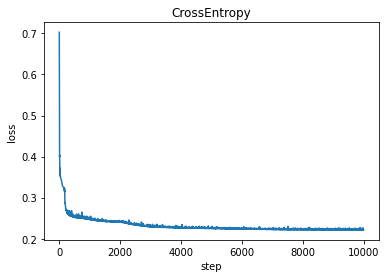

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
losses=[]
for epoch in range(10000):
    optimizer.zero_grad()
    out = net(train_X).squeeze()
    loss = criterion(out.squeeze(), train_y.float())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(epoch/10000 * 100, "%")
        predict_out = net(train_X)
        print("Train Accuracy:",accuracy_score(train_y.data, out.detach().numpy().round()))
        
plt.title("CrossEntropy")
plt.xlabel("step")
plt.ylabel("loss")
print('number of epoch', epoch, 'loss', loss.data)
predict_out = net(train_X)
print("Train Accuracy:",accuracy_score(train_y.data, predict_out.detach().numpy().round()))

predict_out = net(test_X)
print("Test Accuracy:",accuracy_score(test_y.data, predict_out.detach().numpy().round()))
plt.plot(losses)

## Bayesian modelling

### Create the priors

For the prior distributions, I used a set of random variables in a matrix shape for each layer. Each element in the weights matrixes was a Normal distribution with 0 mean and standard deviation of 1.

In [ ]:
weights0 = np.empty_like(net.fc1.weight.data, dtype=object)
weights1 = np.empty_like(net.fc2.weight.data, dtype=object)
weights2 = np.empty_like(net.out.weight.data, dtype=object)

print(weights0.shape)
print(weights1.shape)
print(weights2.shape)

for i in range(weights0.shape[0]):
    for j in range(weights0.shape[1]):
        weights0[i][j] = pm.Normal('weights0_%i%i' % (i, j), 0, 1, value = 0.0)

for i in range(weights1.shape[0]):
    for j in range(weights1.shape[1]):
        weights1[i][j] = pm.Normal('weights1_%i%i' % (i, j), 0, 1, value = 0.0)

for i in range(weights2.shape[0]):
    for j in range(weights2.shape[1]):
        weights2[i][j] = pm.Normal('weights2_%i%i' % (i, j), 0, 1, value = 0.0)    

(4, 2)
(6, 4)
(1, 6)


### Test the learned weights against the function estimated by the Neural Network

In [ ]:
from sklearn.utils.extmath import softmax

def Relu(X):
    return np.maximum(0,X)

def sigmoid(X):
    return 1/(1 + np.exp(-X)) 


# function to check the function approximated by the  
# gradient descent based NN on the provided dataset.
def check_nn(X, weights):
    X = np.array(X)

    # fc1 layer
    n11 = X[:, 0] * weights[0][0][0] + X[:, 1] * weights[0][0][1]
    a11 = np.tanh(n11)

    n12 = X[:, 0] * weights[0][1][0] + X[:, 1] * weights[0][1][1]
    a12 = np.tanh(n12)
    
    n13 = X[:, 0] * weights[0][2][0] + X[:, 1] * weights[0][2][1]
    a13 = np.tanh(n13)

    n14 = X[:, 0] * weights[0][3][0] + X[:, 1] * weights[0][3][1]
    a14 = np.tanh(n14)

    # fc2 layer 
    n21 = a11 * weights[1][0][0] + a12 * weights[1][0][1] + a13 * weights[1][0][2] + a14 * weights[1][0][3]
    a21 = Relu(n21)

    n22 = a11 * weights[1][1][0] + a12 * weights[1][1][1] + a13 * weights[1][1][2] + a14 * weights[1][1][3]
    a22 = Relu(n22)

    n23 = a11 * weights[1][2][0] + a12 * weights[1][2][1] + a13 * weights[1][2][2] + a14 * weights[1][2][3]
    a23 = Relu(n23)

    n24 = a11 * weights[1][3][0] + a12 * weights[1][3][1] + a13 * weights[1][3][2] + a14 * weights[1][3][3]
    a24 = Relu(n24)

    n25 = a11 * weights[1][4][0] + a12 * weights[1][4][1] + a13 * weights[1][4][2] + a14 * weights[1][4][3]
    a25 = Relu(n25)

    n26 = a11 * weights[1][5][0] + a12 * weights[1][5][1] + a13 * weights[1][5][2] + a14 * weights[1][5][3]
    a26 = Relu(n26)

    # out layer 
    n31 = a21 * weights[2][0][0] + a22 * weights[2][0][1] \
        + a23 * weights[2][0][2] + a24 * weights[2][0][3] \
        + a25 * weights[2][0][4] + a26 * weights[2][0][5] \

    return sigmoid(n31)

predict_y = check_nn(train_X, [np.array(net.fc1.weight.data), np.array(net.fc2.weight.data), np.array(net.out.weight.data)])
print("Train Accuracy:",accuracy_score(train_y.data, predict_y.round()))

predict_y = check_nn(test_X, [np.array(net.fc1.weight.data), np.array(net.fc2.weight.data), np.array(net.out.weight.data)])
print("Test Accuracy:",accuracy_score(test_y.data, predict_y.round()))

Train Accuracy: 0.87
Test Accuracy: 0.91


### Model the posterior distribution

To infer the posterior distribution of the weights, a @pm.deterministic function was used to generate a deterministic variable to link the weights priors with the observations in the form of the labels.

Having a binary classification problem, a Bernoulii distribution was used to model the observations.

In [ ]:
@pm.deterministic
def deterministic_NN(X=train_X, weights=[weights0, weights1, weights2]):
    X = np.array(X)

    # fc1 layer
    n11 = X[:, 0] * weights[0][0][0] + X[:, 1] * weights[0][0][1]
    a11 = np.tanh(n11)

    n12 = X[:, 0] * weights[0][1][0] + X[:, 1] * weights[0][1][1]
    a12 = np.tanh(n12)
    
    n13 = X[:, 0] * weights[0][2][0] + X[:, 1] * weights[0][2][1]
    a13 = np.tanh(n13)

    n14 = X[:, 0] * weights[0][3][0] + X[:, 1] * weights[0][3][1]
    a14 = np.tanh(n14)

    # fc2 layer 
    n21 = a11 * weights[1][0][0] + a12 * weights[1][0][1] + a13 * weights[1][0][2] + a14 * weights[1][0][3]
    a21 = Relu(n21)

    n22 = a11 * weights[1][1][0] + a12 * weights[1][1][1] + a13 * weights[1][1][2] + a14 * weights[1][1][3]
    a22 = Relu(n22)

    n23 = a11 * weights[1][2][0] + a12 * weights[1][2][1] + a13 * weights[1][2][2] + a14 * weights[1][2][3]
    a23 = Relu(n23)

    n24 = a11 * weights[1][3][0] + a12 * weights[1][3][1] + a13 * weights[1][3][2] + a14 * weights[1][3][3]
    a24 = Relu(n24)

    n25 = a11 * weights[1][4][0] + a12 * weights[1][4][1] + a13 * weights[1][4][2] + a14 * weights[1][4][3]
    a25 = Relu(n25)

    n26 = a11 * weights[1][5][0] + a12 * weights[1][5][1] + a13 * weights[1][5][2] + a14 * weights[1][5][3]
    a26 = Relu(n26)

    # out layer 
    n31 = a21 * weights[2][0][0] + a22 * weights[2][0][1] \
        + a23 * weights[2][0][2] + a24 * weights[2][0][3] \
        + a25 * weights[2][0][4] + a26 * weights[2][0][5] \

    return sigmoid(n31)

observed = pm.Bernoulli('bernoulli_obs', p=deterministic_NN, value=np.array(train_y), observed=True)

To find the weights posterior distribution the MCMC algorithm was used, providing it the observed Bernoulli distribution and the containers with all the Normal distribution priors of the weights.

In [ ]:
model = pm.Model([observed, pm.Container(weights0), pm.Container(weights1), pm.Container(weights2)])

mcmc = pm.MCMC(model)

mcmc.sample(iter=10000,burn=500)

/usr/local/lib/python3.6/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 10000 of 10000 complete in 151.6 sec

The posterior distributions were calculated and for each weight, the mean of the entire trace was taken into consideration. 

The means of the weight were saved in weights shaped matrixes and then they were used into the check_nn function to see the results of the forward pass using the learned weights in a Bayesian way.

In [ ]:
weights0_trace = np.empty_like(net.fc1.weight.data, dtype=object)
weights1_trace = np.empty_like(net.fc2.weight.data, dtype=object)
weights2_trace = np.empty_like(net.out.weight.data, dtype=object)

for i in range(weights0.shape[0]):
    for j in range(weights0.shape[1]):
        weight_samples = mcmc.trace('weights0_%i%i' % (i, j))[:]
        weights0_trace[i][j] = np.mean(weight_samples)

for i in range(weights1.shape[0]):
    for j in range(weights1.shape[1]):
        weight_samples = mcmc.trace('weights1_%i%i' % (i, j))[:]
        weights1_trace[i][j] = np.mean(weight_samples)

for i in range(weights2.shape[0]):
    for j in range(weights2.shape[1]):
        weight_samples = mcmc.trace('weights2_%i%i' % (i, j))[:] 
        weights2_trace[i][j] = np.mean(weight_samples)

predict_y = check_nn(train_X, [weights0_trace, weights1_trace, weights2_trace])

print("Train Accuracy:",accuracy_score(train_y.data, predict_y.round()))

predict_y = check_nn(test_X, [weights0_trace, weights1_trace, weights2_trace])
print("Test Accuracy:",accuracy_score(test_y.data, predict_y.round()))

Train Accuracy: 0.85625
Test Accuracy: 0.855


## Visualize the final results

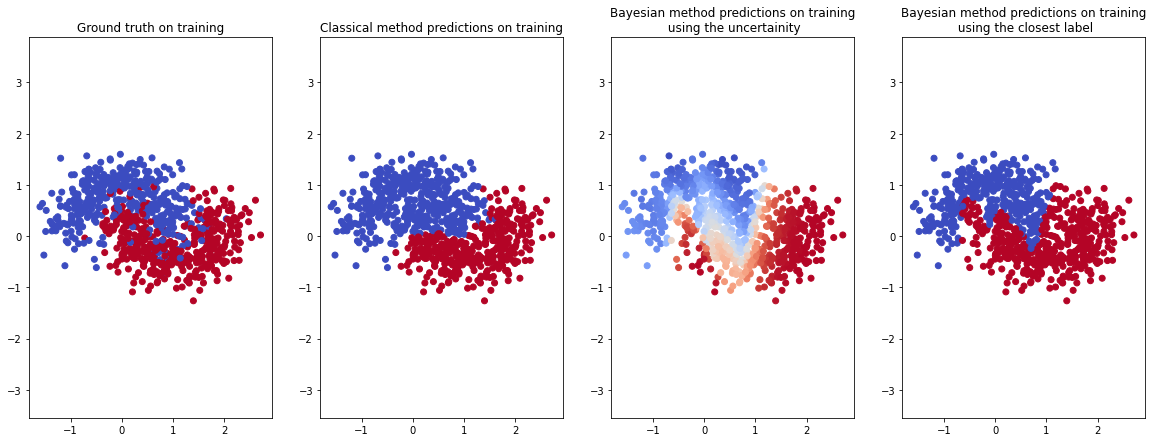

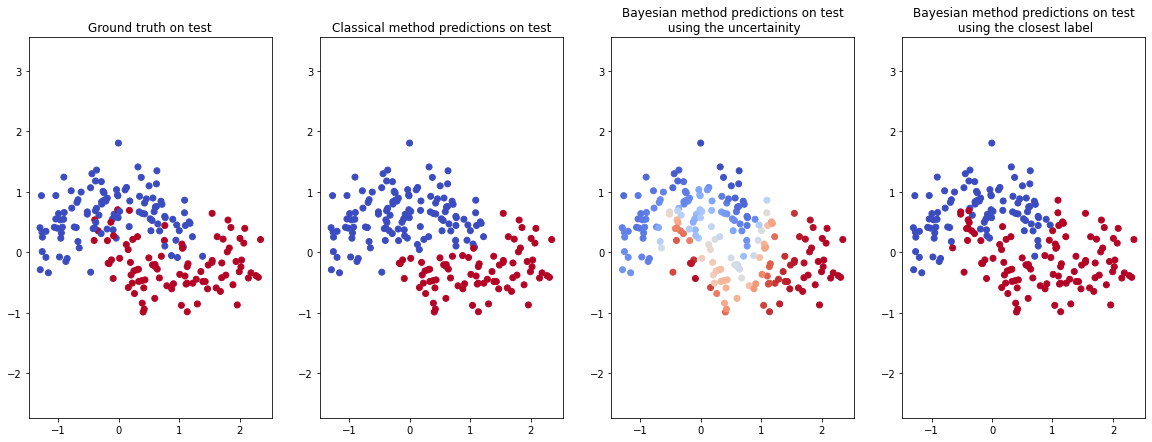

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(141)
plt.scatter(train_X[:,0], train_X[:,1], c=train_y ,cmap=cm.coolwarm)
plt.title('Ground truth on training')
plt.axis('equal');

plt.subplot(142)
plt.scatter(train_X[:,0], train_X[:,1], c=net(train_X).detach().numpy().round(), cmap=cm.coolwarm)
plt.title('Classical method predictions on training')
plt.axis('equal');

plt.subplot(143)
plt.scatter(train_X[:,0], train_X[:,1], c=check_nn(train_X, [weights0_trace, weights1_trace, weights2_trace]), cmap=cm.coolwarm)
plt.title('Bayesian method predictions on training\n using the uncertainity')
plt.axis('equal');

plt.subplot(144)
plt.scatter(train_X[:,0], train_X[:,1], c=check_nn(train_X, [weights0_trace, weights1_trace, weights2_trace]).round(), cmap=cm.coolwarm)
plt.title('Bayesian method predictions on training\n using the closest label')
plt.axis('equal');

plt.figure(figsize=(20,7))
plt.subplot(141)
plt.scatter(test_X[:,0], test_X[:,1], c=test_y ,cmap=cm.coolwarm)
plt.title('Ground truth on test')
plt.axis('equal');

plt.subplot(142)
plt.scatter(test_X[:,0], test_X[:,1], c=net(test_X).detach().numpy().round(), cmap=cm.coolwarm)
plt.title('Classical method predictions on test')
plt.axis('equal');

plt.subplot(143)
plt.scatter(test_X[:,0], test_X[:,1], c=check_nn(test_X, [weights0_trace, weights1_trace, weights2_trace]), cmap=cm.coolwarm)
plt.title('Bayesian method predictions on test\n using the uncertainity')
plt.axis('equal');

plt.subplot(144)
plt.scatter(test_X[:,0], test_X[:,1], c=check_nn(test_X, [weights0_trace, weights1_trace, weights2_trace]).round(), cmap=cm.coolwarm)
plt.title('Bayesian method predictions on test\n using the closest label')
plt.axis('equal');


As can be seen from the plots above, the results of the Bayesian Inference are pretty close to the classical NN results (0.87 vs 0.856 on training set and 0.91 vs 0.855 on test set).

From the plots above you can also see the uncertainity given to the points at the margins of the clusters (the faded points have a greater uncertainty).

Final Results:

| Binary-Classification Problem | Train Accuracy | Test Accuracy |
|-------------------------------|----------------|---------------|
| Classical Neural Network        | 0.87           | 0.91          |
| Bayesian Neural Network       | 0.856          | 0.855         |

# Multiclass Classification

For the multiclass classification I used the make_gaussian_quantiles module from the sklearn.dataset to generate 4 clusters that were not linearly separable. I also added some random noise to the dataset, by using the add_noise function that takes as input the dataset and the noise coefficient.

## Neural Network aproach

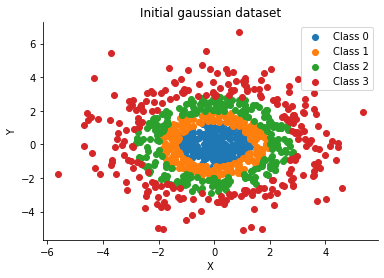

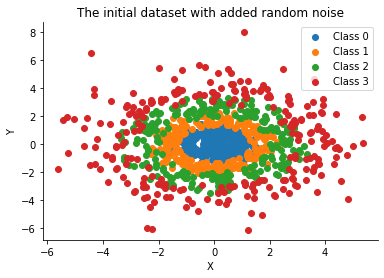

In [ ]:
from sklearn.datasets import make_gaussian_quantiles

X, Y = make_gaussian_quantiles(cov=3.,
                                 n_samples=1000, n_features=2,
                                 n_classes=4, random_state=42)

def add_noise(X, noise_coef):
    for i in range(len(X)):
        if random.randint(0, 1) == 1:
            X[i][0] += X[i][0]*noise_coef
            X[i][1] += X[i][1]*noise_coef 

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], label='Class 1')
ax.scatter(X[Y==2, 0], X[Y==2, 1], label='Class 2')
ax.scatter(X[Y==3, 0], X[Y==3, 1], label='Class 3')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Initial gaussian dataset');

add_noise(X, noise_coef=0.2)

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], label='Class 1')
ax.scatter(X[Y==2, 0], X[Y==2, 1], label='Class 2')
ax.scatter(X[Y==3, 0], X[Y==3, 1], label='Class 3')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='The initial dataset with added random noise');

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=.2)

train_X = torch.Tensor(train_X)
test_X = torch.Tensor(test_X)
train_y = torch.Tensor(train_y).long()
test_y = torch.Tensor(test_y).long()

### Neural network architecture

The network architecture was similar to the one used for the binary classification task, but with the difference that the output layer has an output size of 4 and the output activation function was Softmax not Sigmoid.

In [ ]:
class Multiclass_NN(nn.Module):
	
    def __init__(self):
        super(Multiclass_NN, self).__init__()

        self.fc1 = nn.Linear(2, 4, bias=False)
        self.fc2 = nn.Linear(4, 6, bias=False)
        self.out = nn.Linear(6, 4, bias=False)

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        output = self.fc1(x)
        output = self.tanh(output)
        output = self.fc2(output)
        output = F.relu(output)
        output = self.out(output)
        output = self.softmax(output)

        return output

net = Multiclass_NN()

print(summary(net,(1000,2)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1000, 4]               8
              Tanh-2              [-1, 1000, 4]               0
            Linear-3              [-1, 1000, 6]              24
            Linear-4              [-1, 1000, 4]              24
           Softmax-5              [-1, 1000, 4]               0
Total params: 56
Trainable params: 56
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.17
Params size (MB): 0.00
Estimated Total Size (MB): 0.18
----------------------------------------------------------------
None


### Neural network training

To train the model, the Cross Entropy Loss was used, with the ADAM optimizer and a learning rate of 0.1.

0.0 %
Train Accuracy: 0.26
10.0 %
Train Accuracy: 0.2425
20.0 %
Train Accuracy: 0.2425
30.0 %
Train Accuracy: 0.2425
40.0 %
Train Accuracy: 0.8525
50.0 %
Train Accuracy: 0.8525
60.0 %
Train Accuracy: 0.85875
70.0 %
Train Accuracy: 0.86625
80.0 %
Train Accuracy: 0.8725
90.0 %
Train Accuracy: 0.86875
number of epoch 9999 loss tensor(0.8731)
Train Accuracy: 0.875
Test Accuracy: 0.795


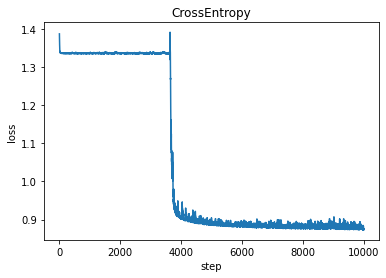

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
losses=[]
for epoch in range(10000):
    optimizer.zero_grad()
    out = net(train_X).squeeze()
    loss = criterion(out.squeeze(), train_y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        # print(out)
        print(epoch/10000 * 100, "%")
        predict_out = net(train_X)
        _, predict_y = torch.max(predict_out, 1)
        print("Train Accuracy:",accuracy_score(train_y.data, predict_y))
        
plt.title("CrossEntropy")
plt.xlabel("step")
plt.ylabel("loss")
print('number of epoch', epoch, 'loss', loss.data)
predict_out = net(train_X)
_, predict_y = torch.max(predict_out, 1)
print("Train Accuracy:", accuracy_score(train_y.data, predict_y))

predict_out = net(test_X)
_, predict_y = torch.max(predict_out, 1)
print("Test Accuracy:", accuracy_score(test_y.data, predict_y))
plt.plot(losses)

## Bayesian modelling

### Create the priors

The same procedure was used to create the priors of the weights, but now, the last set of weights have a different shape

In [ ]:
weights0 = np.empty_like(net.fc1.weight.data, dtype=object)
weights1 = np.empty_like(net.fc2.weight.data, dtype=object)
weights2 = np.empty_like(net.out.weight.data, dtype=object)

print(weights0.shape)
print(weights1.shape)
print(weights2.shape)

for i in range(weights0.shape[0]):
    for j in range(weights0.shape[1]):
        weights0[i][j] = pm.Normal('weights0_%i%i' % (i, j), 0, 1, value = 0.0)

for i in range(weights1.shape[0]):
    for j in range(weights1.shape[1]):
        weights1[i][j] = pm.Normal('weights1_%i%i' % (i, j), 0, 1, value = 0.0)

for i in range(weights2.shape[0]):
    for j in range(weights2.shape[1]):
        weights2[i][j] = pm.Normal('weights2_%i%i' % (i, j), 0, 1, value = 0.0)    

(4, 2)
(6, 4)
(4, 6)


### Test the learned weights against the formula estimated by the Neural Network

In [ ]:
from scipy.special import softmax

def Relu(X):
    return np.maximum(0,X)

def check_nn(X, weights):
    X = np.array(X)

    # fc1 layer
    n11 = X[:, 0] * weights[0][0][0] + X[:, 1] * weights[0][0][1]
    a11 = np.tanh(n11)

    n12 = X[:, 0] * weights[0][1][0] + X[:, 1] * weights[0][1][1]
    a12 = np.tanh(n12)
    
    n13 = X[:, 0] * weights[0][2][0] + X[:, 1] * weights[0][2][1]
    a13 = np.tanh(n13)

    n14 = X[:, 0] * weights[0][3][0] + X[:, 1] * weights[0][3][1]
    a14 = np.tanh(n14)

    # fc2 layer 
    n21 = a11 * weights[1][0][0] + a12 * weights[1][0][1] + a13 * weights[1][0][2] + a14 * weights[1][0][3]
    a21 = Relu(n21)

    n22 = a11 * weights[1][1][0] + a12 * weights[1][1][1] + a13 * weights[1][1][2] + a14 * weights[1][1][3]
    a22 = Relu(n22)

    n23 = a11 * weights[1][2][0] + a12 * weights[1][2][1] + a13 * weights[1][2][2] + a14 * weights[1][2][3]
    a23 = Relu(n23)

    n24 = a11 * weights[1][3][0] + a12 * weights[1][3][1] + a13 * weights[1][3][2] + a14 * weights[1][3][3]
    a24 = Relu(n24)

    n25 = a11 * weights[1][4][0] + a12 * weights[1][4][1] + a13 * weights[1][4][2] + a14 * weights[1][4][3]
    a25 = Relu(n25)

    n26 = a11 * weights[1][5][0] + a12 * weights[1][5][1] + a13 * weights[1][5][2] + a14 * weights[1][5][3]
    a26 = Relu(n26)

    # out layer 
    n31 = a21 * weights[2][0][0] + a22 * weights[2][0][1] \
        + a23 * weights[2][0][2] + a24 * weights[2][0][3] \
        + a25 * weights[2][0][4] + a26 * weights[2][0][5] \

    n32 = a21 * weights[2][1][0] + a22 * weights[2][1][1] \
        + a23 * weights[2][1][2] + a24 * weights[2][1][3] \
        + a25 * weights[2][1][4] + a26 * weights[2][1][5] \

    n33 = a21 * weights[2][2][0] + a22 * weights[2][2][1] \
        + a23 * weights[2][2][2] + a24 * weights[2][2][3] \
        + a25 * weights[2][2][4] + a26 * weights[2][2][5] \

    n34 = a21 * weights[2][3][0] + a22 * weights[2][3][1] \
        + a23 * weights[2][3][2] + a24 * weights[2][3][3] \
        + a25 * weights[2][3][4] + a26 * weights[2][3][5] \

    n_stacked = np.column_stack((n31, n32, n33, n34))

    return softmax(n_stacked, axis=1)

predict_y = check_nn(train_X, [np.array(net.fc1.weight.data), np.array(net.fc2.weight.data), np.array(net.out.weight.data)])
predict_y = np.argmax(predict_y, 1)
print("Train Accuracy:",accuracy_score(train_y.data, predict_y))

predict_y = check_nn(test_X, [np.array(net.fc1.weight.data), np.array(net.fc2.weight.data), np.array(net.out.weight.data)])
predict_y = np.argmax(predict_y, 1)
print("Test Accuracy:",accuracy_score(test_y.data, predict_y))

Train Accuracy: 0.875
Test Accuracy: 0.795


### Model the posterior distribution

Having a multiclass classification problem, a Categorical distribution was used to model the observations.

In [ ]:
@pm.deterministic
def deterministic_NN(X=train_X, weights=[weights0, weights1, weights2]):
    X = np.array(X)

    # fc1 layer
    n11 = X[:, 0] * weights[0][0][0] + X[:, 1] * weights[0][0][1]
    a11 = np.tanh(n11)

    n12 = X[:, 0] * weights[0][1][0] + X[:, 1] * weights[0][1][1]
    a12 = np.tanh(n12)
    
    n13 = X[:, 0] * weights[0][2][0] + X[:, 1] * weights[0][2][1]
    a13 = np.tanh(n13)

    n14 = X[:, 0] * weights[0][3][0] + X[:, 1] * weights[0][3][1]
    a14 = np.tanh(n14)

    # fc2 layer 
    n21 = a11 * weights[1][0][0] + a12 * weights[1][0][1] + a13 * weights[1][0][2] + a14 * weights[1][0][3]
    a21 = Relu(n21)

    n22 = a11 * weights[1][1][0] + a12 * weights[1][1][1] + a13 * weights[1][1][2] + a14 * weights[1][1][3]
    a22 = Relu(n22)

    n23 = a11 * weights[1][2][0] + a12 * weights[1][2][1] + a13 * weights[1][2][2] + a14 * weights[1][2][3]
    a23 = Relu(n23)

    n24 = a11 * weights[1][3][0] + a12 * weights[1][3][1] + a13 * weights[1][3][2] + a14 * weights[1][3][3]
    a24 = Relu(n24)

    n25 = a11 * weights[1][4][0] + a12 * weights[1][4][1] + a13 * weights[1][4][2] + a14 * weights[1][4][3]
    a25 = Relu(n25)

    n26 = a11 * weights[1][5][0] + a12 * weights[1][5][1] + a13 * weights[1][5][2] + a14 * weights[1][5][3]
    a26 = Relu(n26)

    # out layer 
    n31 = a21 * weights[2][0][0] + a22 * weights[2][0][1] \
        + a23 * weights[2][0][2] + a24 * weights[2][0][3] \
        + a25 * weights[2][0][4] + a26 * weights[2][0][5] \

    n32 = a21 * weights[2][1][0] + a22 * weights[2][1][1] \
        + a23 * weights[2][1][2] + a24 * weights[2][1][3] \
        + a25 * weights[2][1][4] + a26 * weights[2][1][5] \

    n33 = a21 * weights[2][2][0] + a22 * weights[2][2][1] \
        + a23 * weights[2][2][2] + a24 * weights[2][2][3] \
        + a25 * weights[2][2][4] + a26 * weights[2][2][5] \

    n34 = a21 * weights[2][3][0] + a22 * weights[2][3][1] \
        + a23 * weights[2][3][2] + a24 * weights[2][3][3] \
        + a25 * weights[2][3][4] + a26 * weights[2][3][5] \

    n_stacked = np.column_stack((n31, n32, n33, n34))

    return softmax(n_stacked, axis=1)

observed = pm.Categorical('categorical_obs', p=deterministic_NN, value=np.array(train_y), observed=True)

In [ ]:
model = pm.Model([observed, pm.Container(weights0), pm.Container(weights1), pm.Container(weights2)])

mcmc = pm.MCMC(model)

mcmc.sample(iter=2000, burn=500)

/usr/local/lib/python3.6/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 2000 of 2000 complete in 85.4 sec

In [ ]:
weights0_trace = np.empty_like(net.fc1.weight.data, dtype=object)
weights1_trace = np.empty_like(net.fc2.weight.data, dtype=object)
weights2_trace = np.empty_like(net.out.weight.data, dtype=object)

for i in range(weights0.shape[0]):
    for j in range(weights0.shape[1]):
        weight_samples = mcmc.trace('weights0_%i%i' % (i, j))[:]
        weights0_trace[i][j] = np.mean(weight_samples)

for i in range(weights1.shape[0]):
    for j in range(weights1.shape[1]):
        weight_samples = mcmc.trace('weights1_%i%i' % (i, j))[:]
        weights1_trace[i][j] = np.mean(weight_samples)

for i in range(weights2.shape[0]):
    for j in range(weights2.shape[1]):
        weight_samples = mcmc.trace('weights2_%i%i' % (i, j))[:] 
        weights2_trace[i][j] = np.mean(weight_samples)

predict_y = check_nn(train_X, [weights0_trace, weights1_trace, weights2_trace])
predict_y = np.argmax(predict_y, 1)
print("Train Accuracy:",accuracy_score(train_y.data, predict_y))

predict_y = check_nn(test_X, [weights0_trace, weights1_trace, weights2_trace])
predict_y = np.argmax(predict_y, 1)
print("Test Accuracy:",accuracy_score(test_y.data, predict_y))

Train Accuracy: 0.8025
Test Accuracy: 0.76


## Visualize the final results

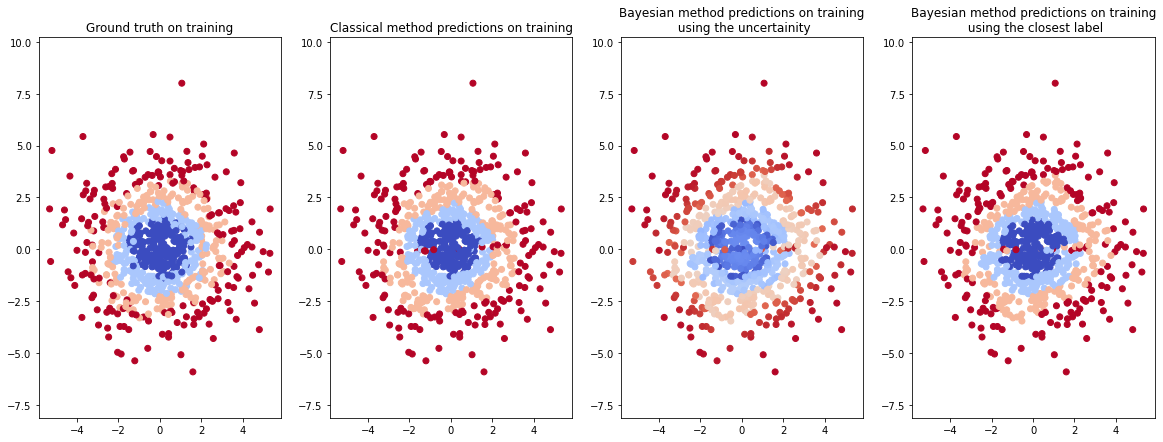

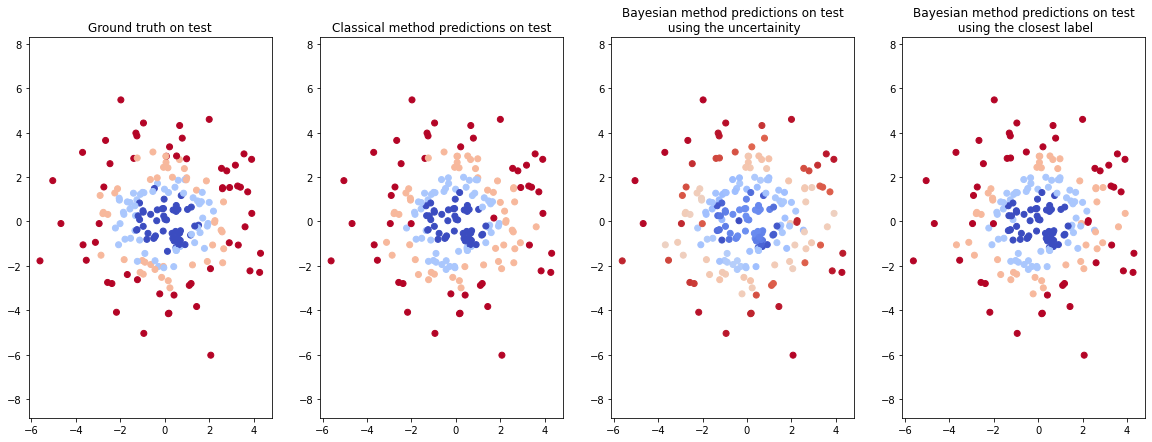

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(141)
plt.scatter(train_X[:,0], train_X[:,1], c=train_y ,cmap=cm.coolwarm)
plt.title('Ground truth on training')
plt.axis('equal');

plt.subplot(142)
predict_out = net(train_X)
_, predict_y = torch.max(predict_out, 1)
plt.scatter(train_X[:,0], train_X[:,1], c=np.array(predict_y), cmap=cm.coolwarm)
plt.title('Classical method predictions on training')
plt.axis('equal');

plt.subplot(143)
predict_y = check_nn(train_X, [weights0_trace, weights1_trace, weights2_trace])
predict_y = np.max(predict_y, 1) + np.argmax(predict_y, 1) 
plt.scatter(train_X[:,0], train_X[:,1], c=predict_y, cmap=cm.coolwarm)
plt.title('Bayesian method predictions on training\n using the uncertainity')
plt.axis('equal');

plt.subplot(144)
predict_y = check_nn(train_X, [weights0_trace, weights1_trace, weights2_trace])
predict_y = np.argmax(predict_y, 1)
plt.scatter(train_X[:,0], train_X[:,1], c=predict_y, cmap=cm.coolwarm)
plt.title('Bayesian method predictions on training\n using the closest label')
plt.axis('equal');


plt.figure(figsize=(20,7))
plt.subplot(141)
plt.scatter(test_X[:,0], test_X[:,1], c=test_y ,cmap=cm.coolwarm)
plt.title('Ground truth on test')
plt.axis('equal');

plt.subplot(142)
predict_out = net(test_X)
_, predict_y = torch.max(predict_out, 1)
plt.scatter(test_X[:,0], test_X[:,1], c=np.array(predict_y), cmap=cm.coolwarm)
plt.title('Classical method predictions on test')
plt.axis('equal');

plt.subplot(143)
predict_y = check_nn(test_X, [weights0_trace, weights1_trace, weights2_trace])
predict_y = np.max(predict_y, 1) + np.argmax(predict_y, 1) 
plt.scatter(test_X[:,0], test_X[:,1], c=predict_y, cmap=cm.coolwarm)
plt.title('Bayesian method predictions on test\n using the uncertainity')
plt.axis('equal');

plt.subplot(144)
predict_y = check_nn(test_X, [weights0_trace, weights1_trace, weights2_trace])
predict_y = np.argmax(predict_y, 1)
plt.scatter(test_X[:,0], test_X[:,1], c=predict_y, cmap=cm.coolwarm)
plt.title('Bayesian method predictions on test\n using the closest label')
plt.axis('equal');

As pointed in the observation done at the binary classification model, the Bayesian model gives a degree of uncertainity to the points at the margins of the clusters (the faded points have a greater uncertainty).

Final Results:

| Multiclass-Classification Problem | Train Accuracy | Test Accuracy |
|-----------------------------------|----------------|---------------|
| Classic Neural Network            | 0.875          | 0.795         |
| Bayesian Neural Network           | 0.8025         | 0.76          |